## Input and Output
Pandas has a lot of functionality, but before you can explore or use it, you'll most likely want to access some data from an external source. You'll also likely want to store results for use later or be able to export results to other tools or to share with others. Pandas has a lot of great options in the area of Input/Output, but with a large number of choices we need to put some thought into what options to use and when.

In this post, I'm going to do a quick overview of some basic I/O for the major options that pandas supports. All of this is available in the documentation, but instead of focusing on details here, I want to get a real world dataset and go over the basic code required to write this data set and then read it back with the same values and types represented in the set. This will give us a basic overview of all of the APIs.

For an input data set, I'll use the [Yahoo! Finance API](https://pypi.org/project/yfinance/) to grab some historical stock market data. This will allow us to see the handling of data types like strings, dates, and numeric values.

All of these examples were first written and tested with Python 3.8.6 and pandas 1.1.4, using a separate virtualenv created using [pyenv](https://www.wrighters.io/2020/11/07/use-pyenv-and-virtual-environments-to-manage-python-complexity).

First, let's install our dependencies using pip (run this cell if needed). If you're using anaconda, you may need to install some of these separately depending on how you setup your environment.

For each of the I/O options below, I'll explain which of these installs are needed.

In [ ]:
%pip install yfinance pandas jupyter matplotlib openpyxl xlrd tables pyarrow

In [2]:
import os

import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

msft = yf.Ticker('MSFT')

prices = msft.history(period='max')

prices.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.056367,0.064656,0.056367,0.061893,1031788800,0.0,0.0
1986-03-14,0.061893,0.065209,0.061893,0.064103,308160000,0.0,0.0
1986-03-17,0.064103,0.065761,0.064103,0.065209,133171200,0.0,0.0
1986-03-18,0.065209,0.065761,0.062998,0.063551,67766400,0.0,0.0
1986-03-19,0.063551,0.064103,0.061893,0.062446,47894400,0.0,0.0


In [3]:
prices.shape

(8757, 7)

In [4]:
prices.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,8757.000000,8757.000000,8757.000000,8757.000000,8.757000e+03,8757.000000,8757.000000
mean,27.605228,27.898439,27.304389,27.611278,5.988022e+07,0.002251,0.001941
std,38.664189,39.066306,38.232989,38.672286,3.865088e+07,0.041333,0.060893
min,0.056367,0.058577,0.056367,0.057472,2.304000e+06,0.000000,0.000000
25%,2.392274,2.422115,2.367407,2.382327,3.601770e+07,0.000000,0.000000
50%,18.598666,18.802277,18.407415,18.580099,5.303360e+07,0.000000,0.000000
75%,26.421556,26.742760,26.166867,26.399563,7.366680e+07,0.000000,0.000000
max,228.671335,232.251952,226.756345,231.045105,1.031789e+09,3.080000,2.000000


In [5]:
prices.index

DatetimeIndex(['1986-03-13', '1986-03-14', '1986-03-17', '1986-03-18',
               '1986-03-19', '1986-03-20', '1986-03-21', '1986-03-24',
               '1986-03-25', '1986-03-26',
               ...
               '2020-11-23', '2020-11-24', '2020-11-25', '2020-11-27',
               '2020-11-30', '2020-12-01', '2020-12-02', '2020-12-03',
               '2020-12-04', '2020-12-07'],
              dtype='datetime64[ns]', name='Date', length=8757, freq=None)

In [6]:
prices.dtypes

Open            float64
High            float64
Low             float64
Close           float64
Volume            int64
Dividends       float64
Stock Splits    float64
dtype: object

<AxesSubplot:xlabel='Date'>

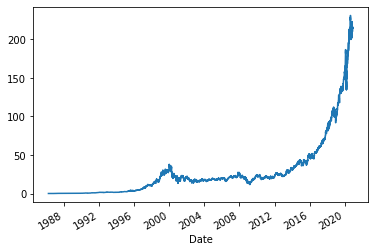

In [7]:
prices['Close'].plot()

## Our data
Now we have a pandas ```DataFrame``` with a date index, floating point values for Open, High, Low, Close, Dividends, and Stock Splits. The Volume is an integer type. This will let us explore some basics for how to persist and read data in the various formats available to us in pandas.

In this post, we'll look at the following formats: CSV, JSON, Microsoft Excel, HDF5, Feather, Parquet, Pickle, and SQL. These are the format that are supported in pandas with ```to_xxx``` methods and provide local storage of data. For each case, we'll look at only the basics of the API so that we can write and read back the ```DataFrame``` with the same datatypes. For each type, we'll also look at a few basics like the size of the file on disk and the time it takes to read and write the data. Note that this is a small ```DataFrame```, so we won't be exploring the true advantages of compression and speed for some of the formats with a smaller amount of data. Later, we can look at that sort of detail.

Note: I don't mention the html format here, since it's not really a good way to store local data, but is more useful for simple web scraping or generating reports. I also won't mention Stata or SAS in this article, mainly because most users will not choose to use either format unless they need to integrate with those platforms, in which case they won't have much choice in the matter of what storage to choose. Also note that Msgpack support was dropped in pandas 1.0, so while it's in the documentation, it's use is discouraged going forward.

For each storage type, I've created a method that takes in the source ```DataFrame``` and writes it out to local storage, then returns the ```DataFrame``` that was created, along with the stat values of the file it was stored in. This will allow us to run some tests on the results and build a summary table of our differences.

I've also created a comparison method that will compare our original ```DataFrame``` with the one that was written to disk and then recreated from the saved data. It should be the same, minus small changes due to the number of significant digits that the storage mechanism will use.

## CSV
First, the most used format for persisting data in the world is probably Comma Separated Values, or CSV. CSV is far from perfect as a format, but is so commonly used that everyone should be able to use it and understand the major issues most users of pandas will encounter with it. The ```DataFrame.to_csv``` and ```pd.read_csv``` methods have a number of arguments and are worthy of a separate article. It's worth noting that the method ```pd.read_table``` is just calling ```read_csv``` but with a Tab (```\t```) as a separator instead of a comma. For now, we will just write our prices ```DataFrame``` as is. When reading our CSV, we need to use a few options to generate a similar result. First, we need to specify our index column so that a new default index is not created, and second, we give the method a hint that our index column is a date so that it can be converted properly.

### Advantages
* Widely supported
* Easy to manipulate and debug with a text editor, or a spreadsheet tool
* No special libraries or tools needed
* Simple to break dataset into smaller chunks

### Disadvantages
1. Not efficient
1. Lossy for some datatypes
1. Not a clear standard, so usually requires some investigation of data to set up
1. Cumbersome for large datasets

In [8]:
def compare_dfs(df1, df2):
    # at a minimum, we expect the index to be an exact match
    assert (df1.index == df2.index).all()
    
    # we also need all the columns to exist
    assert (df1.columns == df2.columns).all()
    
    for col in df1.columns:
        if df1[col].dtype == 'int64':
            # integer columns will be an exact match
            assert (df1[col] == df2[col]).all()
        elif df1[col].dtype == 'float64':
            # floating point will not be exact, but needs to be close
            assert ((df1[col] - df2[col]).abs() < 1e-10).all()

In [9]:
def read_and_write_csv(df, filename):
    df.to_csv(filename)
    df2 = pd.read_csv(filename, index_col=0, parse_dates=[0])
    return df2, os.stat(filename)
    

## JSON
For JSON (JavaScript Object Notation), the ```DataFrame``` is stored as a single object with each column as a member of that object, consisting of members of the keys of the index and values being the values from the column. So it may look something like this:
```
{"Open":{"511056000000":0.0563667971, ..},
 "Close": {"511056000000":0.0533667232, ..}
}
```

In general, I don't see many people using JSON as a storage format for pandas.

### Advantages
* Widely supported
* Somewhat easy to manipulate and debug with a text editor
* No special libraries or tools needed

### Disadvantages
* Not the most efficient and readable method of storage. Hand editing is not simple.
* Very cumbersome with larger datasets

In [10]:
def read_and_write_json(df, filename):
    df.to_json(filename)
    df2 = pd.read_json(filename)
    return df2, os.stat(filename)

## Microsoft Excel
Using the openpyxl and xlrd packages, pandas is able to read and write Excel files. While maybe not the best long term source of storage, being able interact with Excel is a very important feature for many users. If work teams have data already in Excel and maintain it there, being able to read it into pandas is a necessary feature. Also, many third parties build Excel add-ins, so a common workflow can be to pull data into Excel first, then read it into pandas. 

To use Excel, you need to install openpyxl and xlrd.

### Advantages
* Excel can make a great data editor, and it's highly likely to be used by businesses to keep lots of valuable business data.
* Many vendors integrate with Excel, so this can be the quickest and most reliable way to get data into python

### Disadvantages
* To manually edit the file, you need to use a spreadsheet tool like Excel
* Once multiple worksheets are stored in a workbook, life gets a little more complicated
* Maintaining all formatting and formulas, not to mention macros, can be difficult.
* Not good for very large data sets

In [11]:
def read_and_write_excel(df, filename):
    df.to_excel(filename)
    df2 = pd.read_excel(filename, index_col=0)
    return df2, os.stat(filename)

## HDF5
HDF5 is a technology suite that includes a data model, portable file format, software, and a set of tools for managing complex data objects and metadata. For this example, we'll just look at basic persistence. However, HDF5 has support for a number of great features, like extremely large datasets, heirarchical data, and compression.

To use HDF5, you need to install tables.

### Advantages
* Support for large datasets
* Supports hierarchical data
* Advanced tools for maintaining data

### Disadvantages
* More complexity
* More dependencies

In [12]:
def read_and_write_hdf(df, filename):
    df.to_hdf(filename, key='prices', mode='w')
    df2 = pd.read_hdf(filename, key='prices')
    return df2, os.stat(filename)

## Feather
Feather is a format designed specifically for dataframes and is written by pandas creator, Wes McKinney. It's interopable with R, and supports typical data types that would be used in pandas ```DataFrames```, such as timestamps, boolean values, a wide array of numeric types, and categorical values. It's intended to be faster and more efficient than other formats. Feather is now part of the Apache Arrow project.

To use feather, you need to install pyarrow.

### Advantages
* Handles datatypes typical in dataframes better than other formats
* More efficient

### Disadvantages
* Requires other dependencies
* Not as widely supported by other tools

In [13]:
def read_and_write_feather(df, filename):
    # Note that feather doesn't allow for non-default indexes, so the index needs to be stored as a column
    df.reset_index().to_feather(filename)
    df2 = pd.read_feather(filename).set_index('Date')
    return df2, os.stat(filename)

## Parquet
Parquet is a compressed, efficient columnar data representation that was developed for use in the Hadoop ecosystem. The intention is that it support very efficient compression and encoding schemes.

To use parquet, you need to install pyarrow or fastparquet.

### Advantages
* Efficient
* May use much less space
* Supports complex nested data structures

### Disadvantages
* Requires other dependencies
* More complex

In [14]:
def read_and_write_parquet(df, filename):
    df.to_parquet(filename)
    df2 = pd.read_parquet(filename)
    return df2, os.stat(filename)

## Pickle
Pickle support is also built into pandas. For many users, pickle is a good choice for a quick way to save off data and reload it elsewhere since it's built into Python to begin with.

### Advantages
* Widely known

### Disadvantages
* Not inherently secure, shouldn't be trusted when loading from external sources since it can result in code execution
* Not guaranteed to be able to unpickle objects from very old versions of pandas
* Not ideal for sharing data with non-Python users

In [15]:
def read_and_write_pickle(df, filename):
    df.to_pickle(filename)
    df2 = pd.read_pickle(filename)
    return df2, os.stat(filename)

## SQL
Pandas also has wide support for SQL databases, both to read and write data. The backend database can be any database supported by SQLAlchemy with a driver. But without SQLAlchemy installed, the fallback is to use SQLite.

### Advantages
* Widely used
* Databases tools are plentiful and can be used for maintaining data
* Highly likely that many uses cases will require querying a database

### Disadvantages
* Database setups can be complex and require extra infrastructure
* Drivers or extra installs are needed for databases besides SQLite

In [16]:
import sqlite3

def read_and_write_sql(df, filename):
    conn = sqlite3.connect(filename)
    # so we can rerun this method
    conn.execute('drop table if exists prices')
    # this avoids warnings about spaces in column names
    df.columns = [c.replace(' ', '_') for c in df.columns]
    df.to_sql('prices', conn)
    df.columns = [c.replace('_', ' ') for c in df.columns]

    df2 = pd.read_sql('select * from prices', conn, parse_dates=['Date']).set_index('Date')
    df2.columns = [c.replace('_', ' ') for c in df2.columns]

    return df2, os.stat(filename)

For a quick summary of these methods (which I wrote and debugged first), I'll run them all and compare the timings and file sizes for each. Note that I purposefully did not choose any extra compression of this data, even though it is available in some formats. I also am using a fairly small dataframe, so performance improvements for some formats will not show up until dealing with very large datasets.

In [17]:
%timeit read_and_write_csv(prices, 'prices.csv')

125 ms ± 5.52 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
%timeit read_and_write_json(prices, 'prices.json')

49.7 ms ± 2.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [19]:
%timeit read_and_write_excel(prices, 'prices.xlsx')

2.12 s ± 93.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%timeit read_and_write_hdf(prices, 'prices.h5')

15.1 ms ± 521 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
%timeit read_and_write_feather(prices, 'prices.feather')

6.18 ms ± 322 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
%timeit read_and_write_parquet(prices, 'prices.parquet')

20 ms ± 1.08 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
%timeit read_and_write_pickle(prices, 'prices.pkl')

1.82 ms ± 67.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [24]:
%timeit read_and_write_sql(prices, 'prices.db')

68 ms ± 3.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In terms of timing, it's pretty clear that Pickle is the fastest, and hdf5, feather, and parquet are also fairly quick. CSV, JSON, and Excel are much slower. SQL databases will depend a lot on whether the storage is local or not, and if a remote server, how fast the network is and the database server itself. This is just a quick test, a more realistic test would look at various levels of compression, much larger datasets, and different combinations of requirements.

In [25]:
for func, file in [(read_and_write_csv, 'prices.csv'), (read_and_write_json, 'prices.json'),
                   (read_and_write_excel, 'prices.xlsx'), (read_and_write_hdf, 'prices.h5'),
                   (read_and_write_feather, 'prices.feather'), (read_and_write_parquet, 'prices.parquet'),
                   (read_and_write_pickle, 'prices.pkl'), (read_and_write_sql, 'prices.db')]:
    df2, s = func(prices, file)
    compare_dfs(prices, df2)
    print(func, s.st_size/1024)

<function read_and_write_csv at 0x1153e9a60> 879.0390625
<function read_and_write_json at 0x122053ca0> 1543.609375
<function read_and_write_excel at 0x121f5adc0> 570.5078125
<function read_and_write_hdf at 0x121f700d0> 556.3828125
<function read_and_write_feather at 0x121f704c0> 363.087890625
<function read_and_write_parquet at 0x121f70820> 437.927734375
<function read_and_write_pickle at 0x121f70b80> 548.5615234375
<function read_and_write_sql at 0x121f70ee0> 868.0


Because of the repeated text data in the JSON file, it's far larger than any of the other data files. We see feather is the smallest, with parquet also smaller than most of the others. For a better comparison, we should look at each method's storage options, since compression will make a big difference in size, especially for repeated data.

### Conclusion
In summary, pandas has a wide variety of I/O options. Most of the time, choosing which option to use will be dictated by the format in which data is already available. When starting a new project, looking at all the options is a good idea. This post gives a quick overview of what is available in pandas, the basics of calling those APIs, and a rough comparison of data storage size and speed of access. Hopefully ths will motivate you to explore some of the other options that you haven't used yet with pandas.